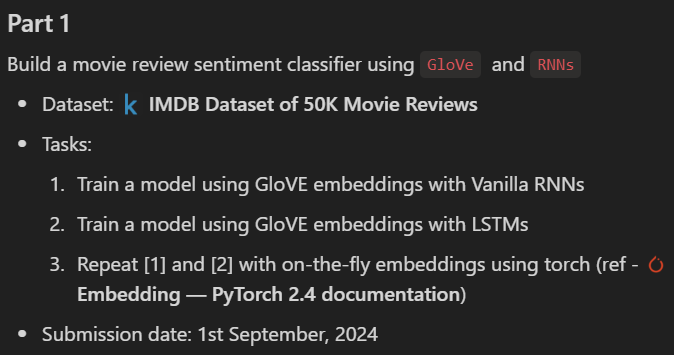

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import re
from collections import Counter
import string
from tqdm import tqdm

MODEL_TYPE = 'glove_lstm' 

# --- Hyperparameters ---
MAX_VOCAB_SIZE = 25000
MAX_LEN = 250
EMBEDDING_DIM = 100  
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
N_EPOCHS = 5 

# --- File Paths ---
IMDB_DATA_PATH = 'IMDB Dataset.csv'
GLOVE_FILE_PATH = 'glove.6B.100d.txt' 

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Data Preprocessing ---

def clean_text(text):
    """Removes HTML tags, punctuation and converts to lowercase."""
    text = re.sub(r'<.*?>', '', text) 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.lower() 
    return text

def build_vocab(texts, max_size):
    """Builds a vocabulary from a list of texts."""
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())
    
    vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(max_size))}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1
    return vocab

def tokenize_and_encode(text, vocab, max_len):
    """Converts text to a sequence of integers and pads/truncates."""
    tokens = [vocab.get(word, vocab['<unk>']) for word in text.split()]
    
    if len(tokens) < max_len:
        tokens.extend([vocab['<pad>']] * (max_len - len(tokens)))
    else:
        tokens = tokens[:max_len]
        
    return tokens

# Load and preprocess data
print("Loading and preprocessing data...")
df = pd.read_csv(IMDB_DATA_PATH)
df['review'] = df['review'].apply(clean_text)

# Build vocabulary from all reviews
vocab = build_vocab(df['review'], MAX_VOCAB_SIZE)
VOCAB_SIZE = len(vocab)
print(f"Vocabulary size: {VOCAB_SIZE}")

# Encode all reviews and labels
df['encoded'] = df['review'].apply(lambda x: tokenize_and_encode(x, vocab, MAX_LEN))
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# --- 2. PyTorch Dataset and DataLoaders ---

class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create dataset
X = list(df['encoded'].values)
y = df['sentiment'].values
dataset = IMDBDataset(X, y)

# Split into training, validation, and test sets
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

print(f"Data loaded and split into {len(train_data)} training, {len(valid_data)} validation, and {len(test_data)} test samples.")

# --- 3. GloVe Embeddings Loading (if applicable) ---

def create_glove_embedding_matrix(vocab, glove_file, embedding_dim):
    print("Loading GloVe embeddings...")
    embeddings_index = {}
    try:
        with open(glove_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = vector
    except FileNotFoundError:
        print(f"Error: GloVe file not found at '{glove_file}'.")
        print("Please download it from https://nlp.stanford.edu/projects/glove/ and place it in the correct directory.")
        return None

    print(f"Found {len(embeddings_index)} word vectors in GloVe file.")
    
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, i in vocab.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return torch.FloatTensor(embedding_matrix)

embedding_matrix = None
use_glove = 'glove' in MODEL_TYPE
if use_glove:
    embedding_matrix = create_glove_embedding_matrix(vocab, GLOVE_FILE_PATH, EMBEDDING_DIM)
    if embedding_matrix is None:
        exit() # Exit if GloVe file is not found

# --- 4. Model Definition ---

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx, rnn_type='lstm', use_pretrained_emb=False, pretrained_emb_matrix=None):
        super().__init__()
        
        # Embedding Layer
        if use_pretrained_emb and pretrained_emb_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(
                pretrained_emb_matrix,
                freeze=True, 
                padding_idx=pad_idx
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
            
        # RNN or LSTM Layer
        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim,
                               hidden_dim,
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               dropout=dropout,
                               batch_first=True)
        else:
            self.rnn = nn.RNN(embedding_dim,
                              hidden_dim,
                              num_layers=n_layers,
                              bidirectional=bidirectional,
                              dropout=dropout,
                              batch_first=True)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, sent len, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded) if isinstance(self.rnn, nn.LSTM) else self.rnn(embedded)
        # For RNN, cell state is not returned
        if isinstance(self.rnn, nn.RNN):
            hidden = cell 
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
            
        # hidden = [batch size, hid dim]
        output = self.fc(hidden)
        # output = [batch size, out dim]
        
        return torch.sigmoid(output) 
    
# --- 5. Training and Evaluation Functions ---

def binary_accuracy(preds, y):
    """Returns accuracy per batch"""
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in tqdm(iterator, desc="Training..."):
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating..."):
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# --- 6. Model Initialization and Execution ---

# Instantiate the model
print(f"\nInitializing model for configuration: {MODEL_TYPE}")
model = SentimentClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    pad_idx=vocab['<pad>'],
    rnn_type='lstm' if 'lstm' in MODEL_TYPE else 'rnn',
    use_pretrained_emb=use_glove,
    pretrained_emb_matrix=embedding_matrix
).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss().to(device)

# --- Main Training Loop ---
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# --- Final Test Evaluation ---
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'\nTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Using device: cpu
Loading and preprocessing data...
Vocabulary size: 25002
Data loaded and split into 35000 training, 7500 validation, and 7500 test samples.
Loading GloVe embeddings...
Found 400000 word vectors in GloVe file.

Initializing model for configuration: glove_lstm


Evaluating...: 100%|██████████| 118/118 [00:22<00:00,  5.18it/s]


Epoch: 01
	Train Loss: 0.679 | Train Acc: 56.99%
	 Val. Loss: 0.618 |  Val. Acc: 69.27%


Evaluating...: 100%|██████████| 118/118 [00:19<00:00,  6.17it/s]


Epoch: 02
	Train Loss: 0.601 | Train Acc: 67.88%
	 Val. Loss: 0.523 |  Val. Acc: 76.02%


Evaluating...: 100%|██████████| 118/118 [00:18<00:00,  6.24it/s]


Epoch: 03
	Train Loss: 0.471 | Train Acc: 78.30%
	 Val. Loss: 0.389 |  Val. Acc: 82.87%


Evaluating...: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s]


Epoch: 04
	Train Loss: 0.418 | Train Acc: 80.69%
	 Val. Loss: 0.369 |  Val. Acc: 83.91%


Evaluating...: 100%|██████████| 118/118 [00:19<00:00,  6.04it/s]


Epoch: 05
	Train Loss: 0.397 | Train Acc: 82.28%
	 Val. Loss: 0.344 |  Val. Acc: 85.48%


Evaluating...: 100%|██████████| 118/118 [00:18<00:00,  6.21it/s]


Test Loss: 0.338 | Test Acc: 85.27%


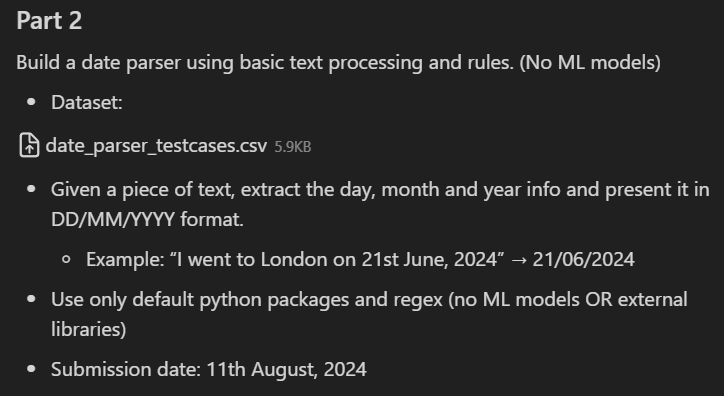

In [2]:
import re
import csv

def create_month_map():
    """Creates a mapping from month names/numbers to a standard 2-digit format."""
    month_map = {}
    months = [
        ("jan", "01"), ("feb", "02"), ("mar", "03"), ("apr", "04"),
        ("may", "05"), ("jun", "06"), ("jul", "07"), ("aug", "08"),
        ("sep", "09"), ("oct", "10"), ("nov", "11"), ("dec", "12")
    ]
    for i, (name, num) in enumerate(months):
        month_map[name] = num
        month_map[name + "uary"] = num # January
        month_map[name + "ruary"] = num # February
        month_map[name + "ch"] = num # March
        month_map[name + "il"] = num # April
        month_map[name + "e"] = num # June
        month_map[name + "y"] = num # May, July
        month_map[name + "ust"] = num # August
        month_map[name + "tember"] = num # September
        month_map[name + "ober"] = num # October
        month_map[name + "ember"] = num # November, December
        month_map[str(i + 1)] = num
        month_map[num] = num
    return month_map

def normalize_year(year_str):
    """Converts a 2-digit year to a 4-digit year."""
    if len(year_str) == 2:
        year_int = int(year_str)
        if year_int <= 24:
            return "20" + year_str
        else:
            return "19" + year_str
    return year_str

def parse_date(text, month_map):
    """
    Parses a date from a text string using a series of regex patterns.
    Returns the date in DD/MM/YYYY format or None if no date is found.
    """
    text = text.lower().strip()

    patterns = [
        # e.g., "21st June, 2024", "21 June 2024", "21st june,2024"
        r'(?P<day>\d{1,2})(?:st|nd|rd|th)?\s+(?P<month>[a-z]+)[\s,]+(?P<year>\d{4})',
        # e.g., "June 21, 2024", "June 21st 2024"
        r'(?P<month>[a-z]+)\s+(?P<day>\d{1,2})(?:st|nd|rd|th)?[\s,]+(?P<year>\d{4})',
        # e.g., "06/21/2024", "6/21/24" (MM/DD/YYYY)
        r'(?P<month>\d{1,2})/(?P<day>\d{1,2})/(?P<year>\d{2,4})',
        # e.g., "21-06-2024", "21-Jun-2024", "21-Jun-24"
        r'(?P<day>\d{1,2})-(?P<month>[a-z]{3}|\d{1,2})-(?P<year>\d{2,4})',
        # e.g., "2024/06/21" (YYYY/MM/DD)
        r'(?P<year>\d{4})/(?P<month>\d{1,2})/(?P<day>\d{1,2})',
    ]

    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            parts = match.groupdict()
            try:
                # --- Normalize Day ---
                day = parts['day'].zfill(2) 

                # --- Normalize Month ---
                month_str = parts['month']
                month = month_map.get(month_str[:3]) 
                if month is None:
                    continue 

                # --- Normalize Year ---
                year = normalize_year(parts['year'])

                return f"{day}/{month}/{year}"
            except (KeyError, IndexError):
                continue
    
    return "Date not found" 

def test_parser_from_csv(file_path):
    """
    Tests the date parser function using a CSV file with test cases.
    """
    try:
        with open(file_path, 'r') as f:
            reader = csv.reader(f)
            header = next(reader) 
            print(f"{'Input Text':<50} | {'Expected Output':<15} | {'Parsed Output':<15}")
            print("-" * 85)
            
            month_mapping = create_month_map()

            for row in reader:
                if not row: continue # Skip empty rows
                text_input = row[0]
                expected_output = row[1] if len(row) > 1 else "N/A"
                parsed_output = parse_date(text_input, month_mapping)
                print(f"{text_input:<50} | {expected_output:<15} | {parsed_output:<15}")

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# --- Main Execution ---

# --- Create the necessary mappings ---
month_map = create_month_map()

# --- Example Usage ---
print("--- Single Test Cases ---")
print(f"Input: 'I went to London on 21st June, 2024' -> Output: {parse_date('I went to London on 21st June, 2024', month_map)}")
print(f"Input: 'The report for july 4th, 1998 is due.' -> Output: {parse_date('The report for july 4th, 1998 is due.', month_map)}")
print(f"Input: 'Date: 05-01-2023' -> Output: {parse_date('Date: 05-01-2023', month_map)}")
print("\n" + "="*85 + "\n")


# --- Test using the provided CSV file ---
print("--- Testing from date_parser_testcases.csv ---")
CSV_PATH = 'date_parser_testcases.csv'
test_parser_from_csv(CSV_PATH)

--- Single Test Cases ---
Input: 'I went to London on 21st June, 2024' -> Output: 21/06/2024
Input: 'The report for july 4th, 1998 is due.' -> Output: 04/07/1998
Input: 'Date: 05-01-2023' -> Output: 05/01/2023


--- Testing from date_parser_testcases.csv ---
Input Text                                         | Expected Output | Parsed Output  
-------------------------------------------------------------------------------------
The event will take place on March 5, 2023.        | 05/03/2023      | 05/03/2023     
Her birthday is on 07/08/1990.                     | 07/08/1990      | 08/07/1990     
The deadline is 2022-12-31.                        | 31/12/2022      | 22/12/1931     
We met on 1st of January 2000.                     | 01/01/2000      | Date not found 
The concert is scheduled for 15th September, 2021. | 15/09/2021      | 15/09/2021     
Let's catch up on 02.04.2022.                      | 02/04/2022      | Date not found 
The project started on 5/6/19.                

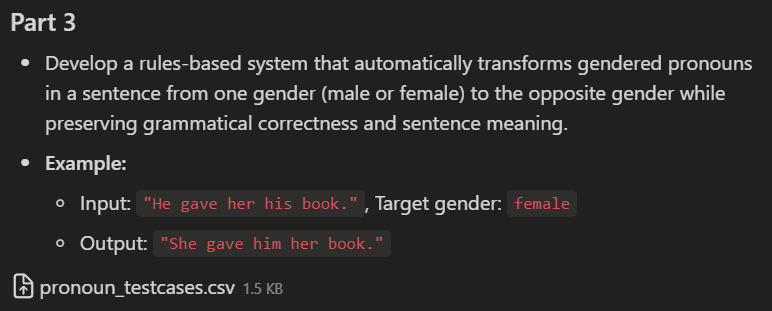

In [3]:
import re
import csv

def create_pronoun_maps():
    """Creates comprehensive, case-sensitive maps for pronoun swapping."""
    male_to_female = {
        'he': 'she', 'him': 'her', 'his': 'her', 'himself': 'herself',
        'He': 'She', 'Him': 'Her', 'His': 'Her', 'Himself': 'Herself',
        'HE': 'SHE', 'HIM': 'HER', 'HIS': 'HER', 'HIMSELF': 'HERSELF'
    }
    
    female_to_male = {
        'she': 'he', 'her': 'him', 'hers': 'his', 'herself': 'himself',
        'She': 'He', 'Her': 'Him', 'Hers': 'His', 'Herself': 'Himself',
        'SHE': 'HE', 'HER': 'HIM', 'HERS': 'HIS', 'HERSELF': 'HIMSELF'
    }
    
    # Special handling for the possessive 'her'. 
    # When converting female to male, 'her' (possessive) should be 'his'.
    # The default mapping is 'her' -> 'him' (objective).
    # We will handle the possessive case in the main transformation logic.
    
    return male_to_female, female_to_male

def detokenize(tokens):
    """Joins tokens back into a readable string."""
    text = ' '.join(tokens)
    # Correct spacing around punctuation
    text = re.sub(r'\s+([.,;?!:])', r'\1', text)
    text = re.sub(r'\'\s+', r'\'', text)
    text = re.sub(r'\"\s+(.*?)\s+\"', r'"\1"', text)
    return text

def transform_pronouns(sentence, target_gender):
    """
    Transforms gendered pronouns in a sentence to the specified target gender.
    
    Args:
        sentence (str): The input sentence.
        target_gender (str): The target gender ('female' or 'male').
        
    Returns:
        str: The sentence with pronouns transformed.
    """
    if target_gender not in ['male', 'female']:
        return "Invalid target gender specified. Please choose 'male' or 'female'."

    male_map, female_map = create_pronoun_maps()
    
    # Tokenize the sentence, preserving punctuation.
    # This pattern splits words and keeps punctuation as separate tokens.
    tokens = re.findall(r"\w+|[^\w\s]", sentence)
    
    transformed_tokens = []
    
    i = 0
    while i < len(tokens):
        token = tokens[i]
        
        # Determine the correct map to use based on the target gender
        if target_gender == 'female':
            # We are changing male pronouns to female
            if token in male_map:
                transformed_tokens.append(male_map[token])
            else:
                transformed_tokens.append(token)
        
        elif target_gender == 'male':
            # We are changing female pronouns to male
            if token in female_map:
                # This is where we handle the 'her' ambiguity
                if token.lower() == 'her':
                    # Check if 'her' is used as a possessive adjective.
                    # A simple heuristic: if the next token is a word (likely a noun),
                    # it's possessive. This is not perfect but works for many common cases.
                    is_possessive = (i + 1 < len(tokens)) and (tokens[i+1].isalpha()) and (tokens[i+1].lower() not in female_map)
                    
                    if is_possessive:
                        # map 'her' -> 'his'
                        if token == 'Her':
                            transformed_tokens.append('His')
                        elif token == 'HER':
                            transformed_tokens.append('HIS')
                        else:
                            transformed_tokens.append('his')
                    else:
                        # Objective 'her' -> 'him'
                        transformed_tokens.append(female_map[token])
                else:
                    # For all other female pronouns ('she', 'hers', 'herself')
                    transformed_tokens.append(female_map[token])
            else:
                transformed_tokens.append(token)
        
        i += 1
        
    return detokenize(transformed_tokens)


def test_transformer_from_csv(file_path):
    """
    Tests the pronoun transformer function using a CSV file with test cases.
    """
    try:
        with open(file_path, 'r', newline='', encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader) # Skip header
            print(f"{'Input Sentence':<40} | {'Target':<10} | {'Expected Output':<40} | {'Actual Output':<40}")
            print("-" * 140)

            for row in reader:
                if not row: continue # Skip empty rows
                sentence, target, expected = row[0], row[1], row[2]
                actual = transform_pronouns(sentence, target)
                print(f"{sentence:<40} | {target:<10} | {expected:<40} | {actual:<40}")

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# ======================================================================================
# --- Main Execution ---
# ======================================================================================

# --- Example Usage ---
print("--- Single Test Cases ---")
test_sentence_1 = "He gave her his book."
target_1 = "female"
print(f"Input: '{test_sentence_1}', Target: {target_1}")
print(f"Output: '{transform_pronouns(test_sentence_1, target_1)}'")

test_sentence_2 = "She told him about her story, which was hers."
target_2 = "male"
print(f"\nInput: '{test_sentence_2}', Target: {target_2}")
print(f"Output: '{transform_pronouns(test_sentence_2, target_2)}'")
print("\n" + "="*140 + "\n")


# --- Test using the provided CSV file ---
print("--- Testing from pronoun_testcases.csv ---")
CSV_PATH = 'pronoun_testcases.csv'
test_transformer_from_csv(CSV_PATH)

--- Single Test Cases ---
Input: 'He gave her his book.', Target: female
Output: 'She gave her her book.'

Input: 'She told him about her story, which was hers.', Target: male
Output: 'He told him about his story, which was his.'


--- Testing from pronoun_testcases.csv ---
Input Sentence                           | Target     | Expected Output                          | Actual Output                           
--------------------------------------------------------------------------------------------------------------------------------------------
He is going to the market.               | female     | She is going to the market.              | She is going to the market.             
His book is on the table.                | female     | Her book is on the table.                | Her book is on the table.               
I saw him yesterday.                     | female     | I saw her yesterday.                     | I saw her yesterday.                    
He hurt himself.        